In [1]:
!pip install openai
!pip install dotenv

In [66]:
import openai
import numpy as np
from scipy.special import softmax
import os
import matplotlib.pyplot as plt
import seaborn as sns
from openai import OpenAI
from tqdm import tqdm
from dotenv import load_dotenv
load_dotenv()

try:
    from google.colab import userdata
    openai_api_key = userdata.get("OPENAI_API_KEY")  # os.getenv("OPENAI_API_KEY")
except:
    print("Not using Colab")
    openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise EnvironmentError("Set your OPENAI_APIKEY as a secret in Colab (or in your bashrc if you are running this locally).")

client = OpenAI(api_key=openai_api_key)

def get_response(prompt):
    response = client.completions.create(
        model="gpt-4o-mini",
        prompt=prompt,
        max_tokens=150,
        top_p=1e-10,
        logprobs=1,
    )
    return response

def get_avg_log_prob(logprobs):
    return sum(logprobs) / len(logprobs)

def compute_perplexity(logprobs):
    avg_logprob = get_avg_log_prob(logprobs)
    return np.exp(-avg_logprob)  # Use base 2 for bits as the unit (=> can be interpreted as num uniform options)

def plot_token_probs(tokens, probs):
    plt.figure(figsize=(12, 4))
    x = np.arange(len(tokens))
    bars = plt.bar(x, probs, color="steelblue", align="center")
    plt.xticks(x, tokens, rotation=70, ha="center", fontsize=8)
    plt.ylabel("P(Token | Context)")
    plt.xlabel("Token")
    plt.title("Token Probabilities")
    plt.tight_layout()
    plt.show()

Not using Colab


Perplexity = $\exp(-\frac{1}{T} \sum_{i=1}^T \log p(o_i))$

Original Output:
def test_add():
    assert add(1, 2) == 3
    assert add(-1, 1) == 0
    assert add(0, 0) == 0
    assert add(-1, -1) == -2
    assert add(1.5, 2.5) == 4.0
    assert add(-1.5, 1.5) == 0.0
    assert add(100, 200) == 300
    assert add(0, 5) == 5
    assert add(5, 0) == 5
    assert add(1, -1) == 0

# To run the

Summary Metrics:
Total tokens:			150
Average log probability:	-0.0984
Perplexity:			1.1031


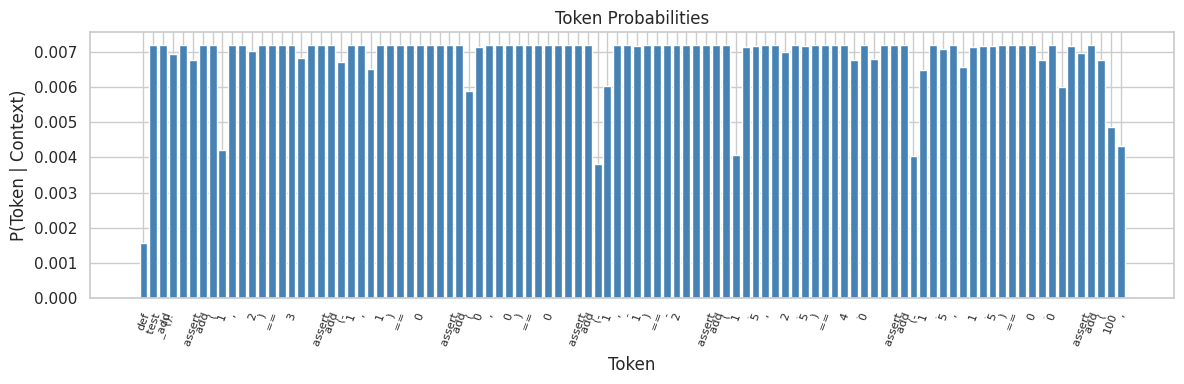

In [67]:
input_fun = """
def add (a, b): 
    return a + b
"""

prompt = f"""Generate a unit test for function: 
{input_fun}
"""

# input_fun = "def add ( a , b ) : return a - b"
# prompt = f"Fix the error in the function: {input_fun}"
words = prompt.split()

# Get response
response = get_response(prompt)
original_output = response.choices[0].text.strip()
tokens = response.choices[0].logprobs.tokens
logprobs = response.choices[0].logprobs.token_logprobs

# Metrics
avg_logprob = get_avg_log_prob(logprobs)
perplexity = compute_perplexity(logprobs)
token_probs = np.exp(logprobs)
normalized_token_probs = softmax(logprobs)

print("Original Output:")
print(original_output)

print("\nSummary Metrics:")
print(f"Total tokens:\t\t\t{len(tokens)}")
print(f"Average log probability:\t{average_logprob:.4f}")
print(f"Perplexity:\t\t\t{perplexity:.4f}")

maxlen = 100
plot_token_probs(tokens[:maxlen], normalized_token_probs[:maxlen])

## Occlusion per line; measure perplexity drop of original output

In [78]:
def mask_line_and_get_perplexity(lines, line_idx, mask_token="[THIS LINE IS OCCLUDED]"):
    masked_lines = lines.copy()
    masked_lines[line_idx] = mask_token
    masked_prompt = "\n".join(masked_lines) + "\n"
    
    # print(masked_prompt)

    response = client.completions.create(
        model="gpt-4o-mini",
        prompt=masked_prompt,
        max_tokens=150,
        top_p=1e-10,
        logprobs=1,
    )
    tokens = response.choices[0].logprobs.tokens
    logprobs = response.choices[0].logprobs.token_logprobs
    avg_logprob = np.mean(logprobs)
    perplexity = np.exp(-avg_logprob)
    return perplexity, response.choices[0].text.strip()

In [79]:
def plot_line_perplexity_drop(lines, line_prob_drops):
    plt.figure(figsize=(12, 4))
    x = np.arange(len(lines))
    
    # Shorten line labels for readability
    short_labels = [line.strip()[:30] + "..." if len(line.strip()) > 10 else line.strip() for line in lines]
    
    bars = plt.bar(x, line_prob_drops, color="steelblue", align="center")
    
    plt.xticks(x, short_labels, rotation=70, ha="center", fontsize=8)
    plt.ylabel("Perplexity Drop")
    plt.xlabel("Masked Line")
    plt.tight_layout()
    plt.show()

Prompt:
Given this function: 

def add (a, b): 
    return a + b

And this unit test:

def test_add():
    assert add(1, 2) == 3
    assert add(-1, 1) == 0
    assert add(0, 0) == 0
    assert add(-1, -1) == 5

Is the test correct?


Lines:
['Given this function: ', 'def add (a, b): ', '    return a + b', 'And this unit test:', 'def test_add():', '    assert add(1, 2) == 3', '    assert add(-1, 1) == 0', '    assert add(0, 0) == 0', '    assert add(-1, -1) == 5', 'Is the test correct?']

Original response:
If not, what is wrong with it? 

The test is not correct. The last assertion `assert add(-1, -1) == 5` is incorrect because the sum of -1 and -1 is -2, not 5. The correct assertion should be `assert add(-1, -1) == -2`. 

So, the test is incorrect due to the last assertion.
Original perplexity: 1.2828

Starting Occlusion...
Masking line 0 (Given this function: ...): drop = -0.0971
Masking line 1 (def add (a, b): ...): drop = 0.0780
Masking line 2 (    return a + b...): drop = 0.0241
M

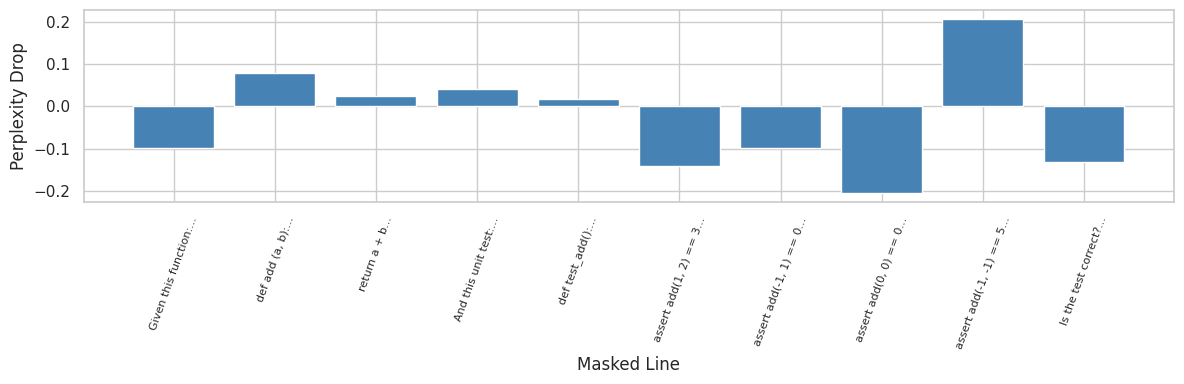

In [83]:
input_fun = """
def add (a, b): 
    return a + b
"""

input_test = """
def test_add():
    assert add(1, 2) == 3
    assert add(-1, 1) == 0
    assert add(0, 0) == 0
    assert add(-1, -1) == 5
"""

prompt = f"""Given this function: 
{input_fun}
And this unit test:
{input_test}
Is the test correct?
"""

# Split prompt into lines
lines = [line for line in prompt.strip().split('\n') if line != ""]

print("Prompt:")
print(prompt)

print("\nLines:")
print(lines)

# Original output logprob
original_response = get_response(prompt)
orig_logprobs = original_response.choices[0].logprobs.token_logprobs
original_perplexity = np.exp(-np.mean(orig_logprobs))

line_prob_drops = []
line_outputs = []

print("\nOriginal response:")
print(original_response.choices[0].text.strip())
print(f"Original perplexity: {original_perplexity:.4f}")

print("\nStarting Occlusion...")
for i in range(len(lines)):
    perplexity_masked, masked_output = mask_line_and_get_perplexity(lines, i)
    drop = perplexity_masked - original_perplexity 
    # If it was bad: higher perplexity afterwards -> high - low = high
    line_prob_drops.append(drop)
    line_outputs.append(masked_output)
    print(f"Masking line {i} ({lines[i][:30]}...): drop = {drop:.4f}")

# Plot perplexity drop    
plot_line_perplexity_drop(lines, line_prob_drops)

In [71]:
# Plot
# annot_labels = [["{:.2f}".format(x) for x in prob_drops]]
# 
# plt.figure(figsize=(max(12, len(words) * 0.6), 2.5))
# sns.heatmap(
#     [prob_drops],
#     annot=annot_labels,
#     fmt="",
#     cmap="coolwarm",
#     cbar_kws={"label": "Prob Drop"},
#     xticklabels=words,
#     yticklabels=[],
#     vmin=0,
#     vmax=1
# )
# 
# plt.title("Occlusion Heatmap: Word Influence on Output Probability", fontsize=14)
# plt.xticks(rotation=45, ha="right")
# plt.yticks([])
# plt.tight_layout()
# plt.show()

Extract top tokens and regenerate prompt

In [6]:
def extract_top_tokens(matrix, top_n=5):
    # Sort tokens by importance (descending), take top N
    sorted_tokens = sorted(matrix, key=lambda x: x[1], reverse=True)
    top_tokens = [token for token, _ in sorted_tokens[:top_n]]
    return top_tokens

def generate_focused_text(top_tokens, new_prompt):
    updated_response = client.completions.create(
          model="gpt-4o-mini",
          prompt=new_prompt,
          max_tokens=160,
          logprobs=1,  # get many token logprobs
          top_p=1e-10,
    )
    return updated_response.choices[0].text.strip()

In [13]:
matrix = list(zip(words, prob_drops))
top_tokens = extract_top_tokens(matrix, top_n=5)
print(f"Top tokens: {top_tokens}")
# new_prompt = f"Improve the following text while preserving its original intent. Focus and provide explaination on these key tokens: {', '.join(top_tokens)}. Text: {prompt}"
# new_prompt = f"Improve the given text while preserving its original intent. Focus on these key tokens: {', '.join(top_tokens)}. Text to be improved: {prompt}"
# new_prompt = f"Improve the given text while focusing on these key tokens: {', '.join(top_tokens)}. Text to be improved: {prompt}"
# new_prompt = f"Focus on these key tokens: '{', '.join(top_tokens)}'. Text to be improved: {prompt}"
updated_prompt = f"Old prompt: {prompt} Focus on these key tokens: '{', '.join(top_tokens)}'. Response from old prompt: {original_output}. Improve the old prompt"
result_text = generate_focused_text(top_tokens,updated_prompt)

print(f"First prompt: {prompt}")
print()
print(f"Original output: {original_output}")
print()
print(f"Second prompt: {updated_prompt}")
print()
print(f"Second output: {result_text}")

Top tokens: ['a', 'test', 'Generate', 'unit', 'b']
First prompt: Generate a unit test for function: def add ( a , b ) : return a + b

Original output: Here is a simple unit test for the `add` function:

```python
import unittest

def add(a, b):
    return a + b

class TestAddFunction(unittest.TestCase):
    def test_add_positive_numbers(self):
        self.assertEqual(add(1, 2), 3)
        
    def test_add_negative_numbers(self):
        self.assertEqual(add(-1, -2), -3)
        
    def test_add_mixed_numbers(self):
        self.assertEqual(add(-1, 1), 0)
        
    def test_add_zero(self):
        self.assertEqual(add(0, 0), 0)
        self.assertEqual(add(0, 5), 5)
        self.assertEqual(add

Second prompt: Old prompt: Generate a unit test for function: def add ( a , b ) : return a + b Focus on these key tokens: 'a, test, Generate, unit, b'. Response from old prompt: Here is a simple unit test for the `add` function:

```python
import unittest

def add(a, b):
    return a + b



Softmax Heatmap (just testing)

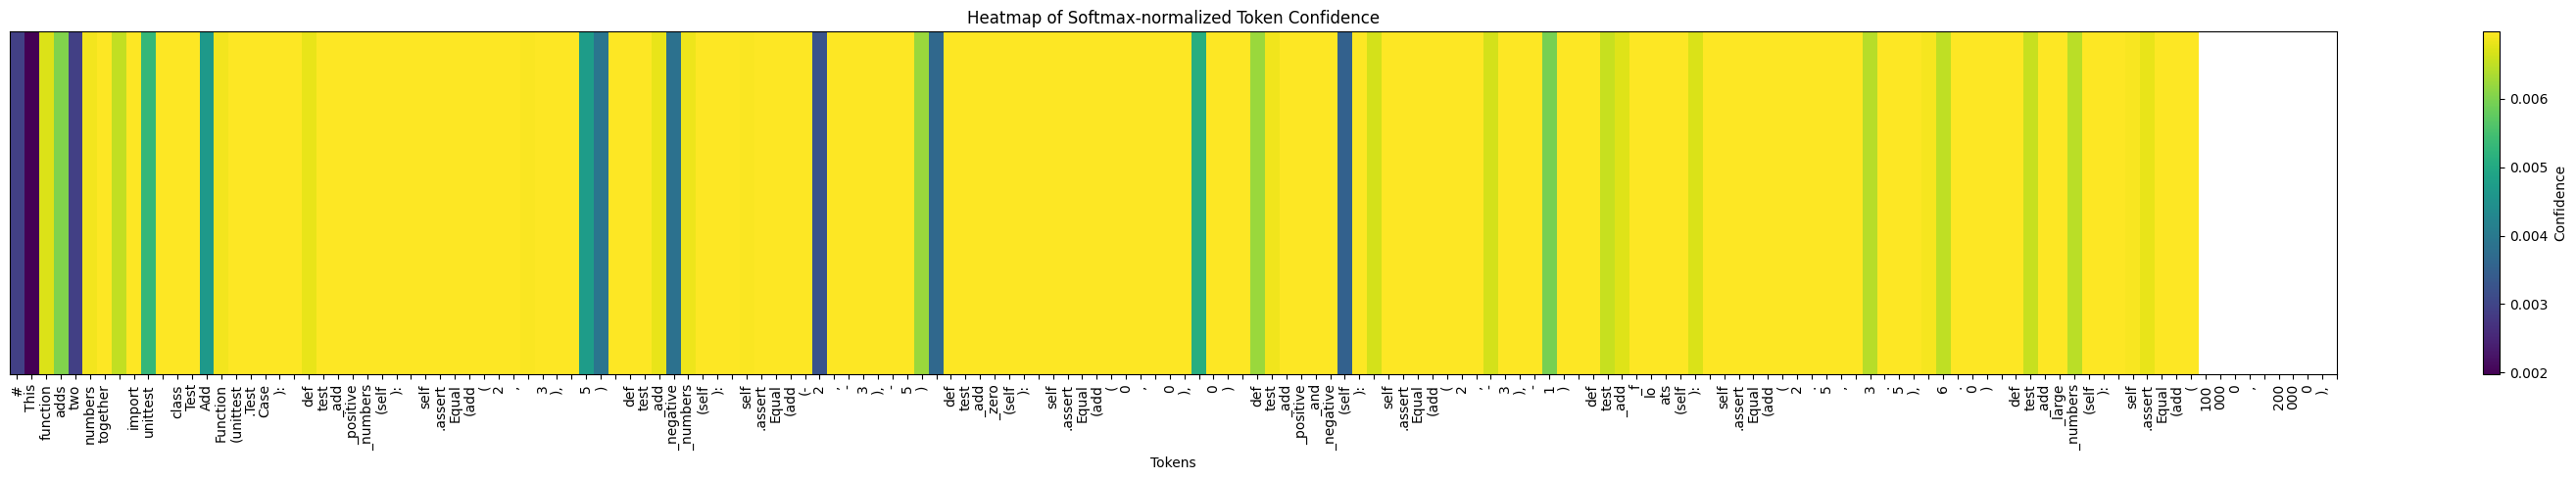

In [ ]:
# Reshape to 2D array (1 row, N columns) for heatmap
heatmap_data = np.array(normalized_token_probs).reshape(1, -1)

plt.figure(figsize=(30, 5))
plt.imshow(heatmap_data, aspect='auto', cmap='viridis')

plt.colorbar(label='Confidence')

# Set x-ticks with tokens, rotate for readability
plt.xticks(ticks=np.arange(len(tokens)), labels=[t.strip() for t in tokens], rotation=90)
plt.yticks([])  # Hide y-axis ticks since only one row

plt.title("Heatmap of Softmax-normalized Token Confidence")
plt.xlabel("Tokens")

plt.tight_layout()
plt.show()
